The qubo is: {('x_1', 's_1'): -4.0, ('x_2', 'x_0'): 5.0, ('x_0', 'x_0'): 1.0, ('x_4', 'x_3'): 5.0, ('x_4', '0*1'): -10.0, ('x_3', 'x_2'): 8.0, ('x_0', 's_0'): -2.0, ('x_3', 'x_0'): 5.0, ('x_4', 'x_2'): 5.0, ('x_2', 's_1'): -4.0, ('x_2', 'x_1'): 5.0, ('x_4', '0*2'): -10.0, ('x_3', 's_0'): -2.0, ('0*2', '4*5'): 2.0, ('x_1', 's_0'): -2.0, ('x_2', 's_0'): -2.0, ('x_4', 's_0'): -2.0, ('0*1', '4*5'): 2.0, ('x_3', 'x_1'): 336.0, ('s_0', 's_1'): 4.0, ('x_4', 'x_1'): 2.0, ('x_3', '2*4'): -10.0, ('x_5', 's_0'): -2.0, ('x_5', 'x_1'): 24.0, ('s_0', 'x_6'): -2.0, ('x_2', '0*2'): 2.0, ('x_1', '3*5'): -10.0, ('3*5', '0*1'): 2.0, ('x_5', '0*1'): -10.0, ('x_3', 'x_3'): -28.0, ('x_4', 's_1'): -4.0, ('x_4', 'x_6'): 2.0, ('s_1', 'x_6'): -4.0, ('x_5', 's_1'): -4.0, ('x_5', 'x_6'): 2.0, ('x_3', 'x_6'): 2.0, ('x_5', '1*3'): -10.0, ('x_3', 's_1'): -4.0, ('x_4', 'x_0'): 2.0, ('x_2', 'x_6'): 2.0, ('x_0', 's_1'): -4.0, ('x_0', 'x_6'): 2.0, ('x_0', '4*5'): -10.0, ('x_1', 'x_6'): 2.0, ('x_1', '4*5'): -10.0, ('x_0'

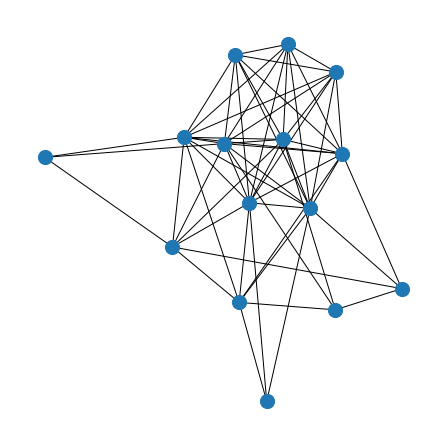

Las variables solución son: {'0*1': 0, '0*2': 1, '1*3': 0, '2*4': 0, '3*5': 1, '4*5': 0, 's_0': 0, 's_1': 0, 'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 1, 'x_4': 1, 'x_5': 0, 'x_6': 1}

energía del sistema: -51.0
{'s_1': 0, '4*5': 0, 'x_6': 1, '0*1': 0, '3*5': 1, '0*2': 1, '2*4': 0, 'x_1': 0, '1*3': 0, 's_0': 0, 'x_0': 0, 'x_2': 0, 'x_3': 1, 'x_4': 1, 'x_5': 0}
{'const_1': (True, 0.0), 'const_2': (False, 1.0)}
{'const_2': (False, 1.0)}


In [6]:
import dimod
import json
import matplotlib.pyplot as plt
import networkx as nx

from pyqubo import Binary, Placeholder, Constraint
from dimod import SimulatedAnnealingSampler
from dimod.serialization.json import DimodEncoder

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import InequalityToEquality, QuadraticProgramToQubo, LinearInequalityToPenalty, LinearEqualityToPenalty, IntegerToBinary
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance

x = []

for i in range(7):  #En nuestro problema hay 7 variables binarias : x0,x1,x2,x3,x4,x5,x6 . Las implementamos : 
    x.append(Binary(f'x_{i}'))
#Definimos nuestra función QUBO que queremos optimizar :  
Q = 6*x[0] + x[1] + 4*x[2] - 23*x[3] - 7*x[4] + 8*x[5] - 9*x[6] + 3*x[0]*x[2] - 23*x[1]*x[2] - 7*x[0]*x[1] + 2*x[0]*x[3] + 3*x[4]*x[2] + 22*x[1]*x[5] + 334*x[1]*x[3] - 3*x[3]*x[4] - 3*x[5]*x[2] + 5*x[2]*x[3]

#Creamos diccionario :
qubo = {('x_0', 'x_1'): -7.0, ('x_0', 'x_3'): 2.0, ('x_1', 'x_5'): 22.0, ('x_0', 'x_0'): 6.0, ('x_2', 'x_3'): 5.0, ('x_2', 'x_2'): 4.0, ('x_2', 'x_5'): -3.0, ('x_0', 'x_2'): 3.0, ('x_1', 'x_2'): -23.0, ('x_2', 'x_4'): 3.0, ('x_3', 'x_4'): -3.0, ('x_5', 'x_5'): 8.0, ('x_1', 'x_3'): 334.0, ('x_4', 'x_4'): -7.0, ('x_3', 'x_3'): -23.0, ('x_1', 'x_1'): 1.0, ('x_6', 'x_6'): -9.0}


M = 5  #Buscaremos M (el peso de penalización o peso de la restricción en nuestro problema).Creamos, por tanto, un QUBO con diferentes valores de M para ver cuál es más óptimo . En nuestro ejemplo probamos con M=5 y M= 6 

s_0, s_1 = Binary('s_0'), Binary('s_1') #Como la primera restricción es una desigualdad, necesitamos variables auxiliares para convertirla en igualdad. 


# defining the constraint
const_1 = 0

for i in range(7): #Recordemos que en nuestro problema tenemos 7 variables
    const_1 +=x[i]
    
const_1 += -s_0 - 2*s_1 - 3  #La restricción es > , luego tendremos que restar las variables de holgura para convertirlo en = (si fuera < , las sumaríamos) 
    
#Nuestra función de coste será la función Q definida arriba , pero añadiendo ahora la restricción(elevada al cuadrado, para evitar valores negativos de la misma) 
Q += Constraint(const_1**2, label='const_1')

#Pasamos ahora a trabajar la segunda restricción . Llamamos P al penalty de esta segunda restricción(lo que era M en la primera)
P = Placeholder('P') #Si usamos placeholder, podemos cambiar el valor de P sin tener que compilar cada vez. Así podemos ir modificando el peso de la restricción de forma más dinámica

const_2 = 0

for i in range(5): #Nuestra segunda restricción considera los valores x[i] y x[i+2] y tenemos un total de 7 variables, desde x[0] hasta x[7] , con lo cual i como mucho puede llegar hasta 5 porque 5+2 = 7
    const_2 += x[i]*x[i+1]
#Implementamos nuestra función de coste ya con la segunda restricción incluida(como explicamosantes, también elevada al cuadrado)    
Q += Constraint(const_2**2, label='const_2')

#Compilamos probando con el valor P = 8 e imprimimos el resultado en pantalla : 
model = Q.compile()
qubo, offset = model.to_qubo(feed_dict={'P': 8})

print('The qubo is:', qubo)
print('\nThe offset is:', offset)

# Vemos el resultado gráficamente : 

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo,offset)

G = dimod.to_networkx_graph(bqm)
plt.figure(figsize=(6, 6))
nx.draw(G, node_size=200)
plt.show()

#Ejecutamos en sampler : 
solution = dimod.SimulatedAnnealingSampler().sample_qubo(qubo)

print('Las variables solución son:', solution.first.sample)
print('\nenergía del sistema:', solution.first.energy)

# Analizamos si el resultado es bueno; es decir , si las restricciones se satisfacen o no : 

decoded_sample = model.decode_sample(solution.first.sample, vartype='BINARY')
print(decoded_sample.sample)

# Restricciones que tenemos en el problema : 

print(decoded_sample.constraints())

# Restricciones no satisfechas : 

print(decoded_sample.constraints(only_broken=True))


